# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \theta & \dot{x} & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
from ilqr.cost import QRCost, FiniteDiffCost
from ilqr.mujoco_dynamics import MujocoDynamics
from ilqr.mujoco_controller import iLQR
from ilqr.examples.cartpole import CartpoleDynamics
from ilqr.dynamics import constrain

from scipy.optimize import approx_fprime

import mujoco_py
from mujoco_py import MjViewer
import os

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
xml_path = os.path.join('..', 'ilqr', 'xmls', 'inverted_double_pendulum.xml')
dynamics = MujocoDynamics(xml_path, frame_skip = 4)
print(dynamics.dt)

0.04


In [7]:
print(dynamics.state_size)
x_goal = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 10.0
Q[1, 1] = 10.0
Q[2, 2] = 10.0


# Terminal state cost.
Q_terminal = 100 * Q

# Instantaneous control cost.
R = 10 * np.eye(1)

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

6


In [8]:
N = 100
x0 = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost1, N)

In [9]:
t0 = time.time()
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print('\n\n\n\n\n')
print('time', time.time() - t0)

iteration 0 accepted 490406.9403585197 [ 2.38311318 18.65709727  0.53890629 10.01600782 -6.7827207  15.83762079]
iteration 1 accepted 429203.0321642433 [ 1.8991771  17.78495395  1.05852753  8.45310179 -5.20738311  9.28447937]
iteration 2 accepted 414058.4371940872 [ 0.4336246  17.94731776  0.71975657  5.43778391 -3.71791698  7.86986896]
iteration 3 accepted 410232.4584981933 [ 0.51011484 17.8302042   0.5453079   5.37252933 -3.91226465  8.13760656]
iteration 4 accepted 407057.12776003696 [ 0.38601439 17.65739089  0.55150262  5.45612037 -6.12657457  6.81713632]
iteration 5 accepted 400664.56903578603 [ 0.10190621 17.49667861  1.10809206  4.95143015 -3.68744     7.10560718]
iteration 6 accepted 399450.33291021554 [ 0.82694437 17.46114012  0.9405291   4.61298583 -4.02492231  8.09467898]
iteration 7 accepted 380260.7997989677 [-0.83307737 17.20530237  0.60545902  0.10399384  2.57269174 -5.01793928]
iteration 8 accepted 229860.730961075 [ 1.07537194  8.08928363  4.07417455  5.24688437 -6.866

iteration 72 failed 145100.4174136749 [ 0.69421604  7.00883042  1.95520463  3.72576054 -5.85639468 -8.93966765]
iteration 73 accepted 145011.24203335866 [ 0.69102443  7.00628368  1.95411515  3.73064883 -5.84847375 -8.93486806]
iteration 74 accepted 144987.499681796 [ 0.69058938  7.00562867  1.95369965  3.73159308 -5.84582232 -8.93307478]
iteration 75 failed 144987.499681796 [ 0.69058938  7.00562867  1.95369965  3.73159308 -5.84582232 -8.93307478]
iteration 76 accepted 144967.9670063428 [ 0.68990503  7.00498468  1.95341609  3.73338512 -5.84430738 -8.9319274 ]
iteration 77 failed 144967.9670063428 [ 0.68990503  7.00498468  1.95341609  3.73338512 -5.84430738 -8.9319274 ]
iteration 78 accepted 144948.05307610793 [ 0.68915921  7.00430261  1.95314842  3.7351872  -5.84292995 -8.93083803]
iteration 79 failed 144948.05307610793 [ 0.68915921  7.00430261  1.95314842  3.7351872  -5.84292995 -8.93083803]
iteration 80 failed 144948.05307610793 [ 0.68915921  7.00430261  1.95314842  3.7351872  -5.8429

iteration 144 accepted 141617.45082823193 [ 0.41712193  6.96170047  1.89783035  3.66226473 -5.49231758 -8.7987238 ]
iteration 145 accepted 141521.01971140088 [ 0.41589288  6.95717654  1.89562502  3.67032704 -5.47693071 -8.7931096 ]
iteration 146 failed 141521.01971140088 [ 0.41589288  6.95717654  1.89562502  3.67032704 -5.47693071 -8.7931096 ]
iteration 147 failed 141521.01971140088 [ 0.41589288  6.95717654  1.89562502  3.67032704 -5.47693071 -8.7931096 ]
iteration 148 failed 141521.01971140088 [ 0.41589288  6.95717654  1.89562502  3.67032704 -5.47693071 -8.7931096 ]
iteration 149 accepted 141238.13903763748 [ 0.4120197   6.9618164   1.89815576  3.66012503 -5.49546848 -8.79625215]
iteration 150 failed 141238.13903763745 [ 0.4120197   6.9618164   1.89815576  3.66012503 -5.49546848 -8.79625215]
iteration 151 accepted 141169.69461619674 [ 0.41108752  6.96374827  1.89912586  3.65616601 -5.50243894 -8.79762287]
iteration 152 failed 141169.69461619676 [ 0.41108752  6.96374827  1.89912586  3.

iteration 219 failed 138969.20905601792 [ 0.3849037   6.94104656  1.90363304  3.65308959 -5.53239535 -8.80874938]
iteration 220 accepted 138896.01780450958 [ 0.38447676  6.94125287  1.90364905  3.65273151 -5.53245975 -8.80851942]
iteration 221 accepted 138882.34513748228 [ 0.38563179  6.94016438  1.90324753  3.65545717 -5.53000816 -8.80820275]
iteration 222 accepted 138836.37689082162 [ 0.38677618  6.94220436  1.90415757  3.6493695  -5.53612765 -8.80832017]
iteration 223 failed 138836.37689082162 [ 0.38677618  6.94220436  1.90415757  3.6493695  -5.53612765 -8.80832017]
iteration 224 failed 138836.37689082162 [ 0.38677618  6.94220436  1.90415757  3.6493695  -5.53612765 -8.80832017]
iteration 225 accepted 138816.6501269946 [ 0.38656789  6.94201055  1.90408621  3.64948149 -5.53572436 -8.80792193]
iteration 226 failed 138816.6501269946 [ 0.38656789  6.94201055  1.90408621  3.64948149 -5.53572436 -8.80792193]
iteration 227 accepted 138797.42956559965 [ 0.38635486  6.94183531  1.90402202  3.

iteration 294 accepted 137070.0670712569 [ 0.30632154  6.94599567  1.90643987  3.63552519 -5.5616495  -8.72451427]
iteration 295 accepted 134886.54050023956 [ -0.28232199   4.8711846    2.85387212  -0.06402157 -14.94145638
  -5.09284813]
iteration 296 accepted 131537.07148018217 [ -0.31205678   4.97356826   2.84724389  -0.32889842 -13.76829266
  -5.06448924]
iteration 297 accepted 130997.52386508016 [ -0.22879673   4.89011683   2.73260828  -0.04522201 -13.76570805
  -6.52453488]
iteration 298 accepted 129555.79282268 [ -0.1848563    4.86964742   2.70863022  -0.05641717 -13.55557368
  -6.72562118]
iteration 299 accepted 127178.1986166419 [ -0.16558643   4.8952908    2.69655925  -0.23390882 -12.89527888
  -6.65046175]
iteration 300 accepted 125397.82794320266 [ -0.14211671   4.8888186    2.68844033  -0.39630589 -12.50651013
  -6.54932776]
iteration 301 accepted 124029.5279887104 [ -0.11213793   4.86117589   2.66816981  -0.49680697 -12.25317373
  -6.62111865]
iteration 302 accepted 122906

iteration 365 accepted 102902.1955350151 [ 0.58870164  4.47289136  1.98878011 -0.12155502 -5.94299253 -7.96346224]
iteration 366 accepted 102893.0453878815 [ 0.58792134  4.47337018  1.98868021 -0.12533068 -5.93907705 -7.95979954]
iteration 367 accepted 102884.00725204922 [ 0.58713966  4.47384773  1.98858109 -0.12905055 -5.9351854  -7.95617467]
iteration 368 accepted 102882.22509169069 [ 0.58698444  4.47394412  1.98856042 -0.12977761 -5.93440102 -7.95546325]
iteration 369 accepted 102880.44733928461 [ 0.58682916  4.47404045  1.98853979 -0.13050248 -5.93361767 -7.95475334]
iteration 370 failed 102880.44733928458 [ 0.58682916  4.47404045  1.98853979 -0.13050248 -5.93361767 -7.95475334]
iteration 371 failed 102880.44733928458 [ 0.58682916  4.47404045  1.98853979 -0.13050248 -5.93361767 -7.95475334]
iteration 372 failed 102880.44733928458 [ 0.58682916  4.47404045  1.98853979 -0.13050248 -5.93361767 -7.95475334]
iteration 373 failed 102880.44733928458 [ 0.58682916  4.47404045  1.98853979 -0.

In [10]:
t = np.arange(N + 1) * dynamics.dt
x = xs[:, 0]
x_dot = xs[:, 2]
theta = np.unwrap(xs[:, 1])  # Makes for smoother plots.
theta_dot = xs[:, 3]

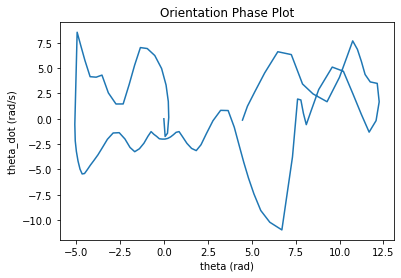

In [11]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

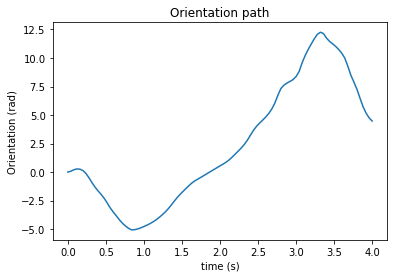

In [12]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

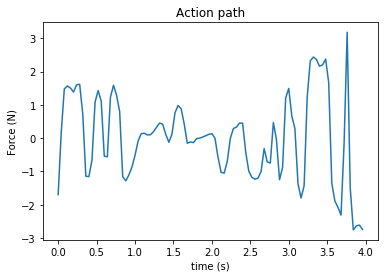

In [13]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

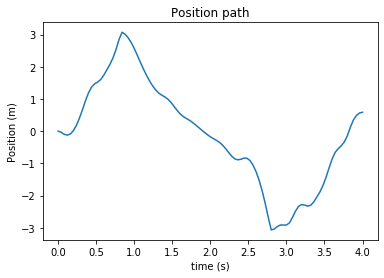

In [14]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

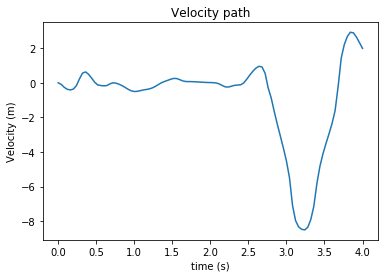

In [15]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

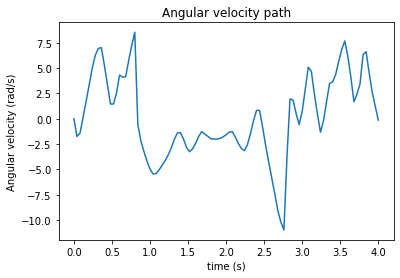

In [16]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

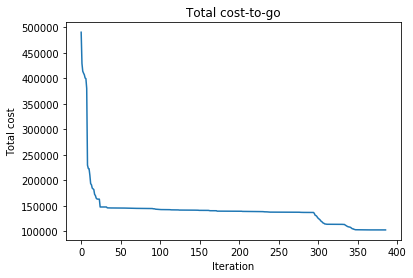

In [17]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [18]:
viewer = MjViewer(dynamics.sim)
dynamics.set_state(x0)
print(dynamics.get_state())
for i, u in enumerate(us):
    print (i, u)
    print(xs[i+1], dynamics.step(u))
    print('')
    viewer.render()

Creating window glfw
[0. 0. 0. 0. 0. 0.]
0 [-1.69385921]
[-0.03495073  0.07244414 -0.09267471 -1.74723469  3.62459304 -4.62823124] [-0.03495073  0.07244414 -0.09267471 -1.74723469  3.62459304 -4.62823124]

1 [0.18121124]
[-0.09836673  0.20626843 -0.26455961 -1.42826032  3.11077489 -4.05877831] [-0.09836673  0.20626843 -0.26455961 -1.42826032  3.11077489 -4.05877831]

2 [1.47958736]
[-0.12393508  0.27792938 -0.37662457  0.13733423  0.56128057 -1.7762037 ] [-0.12393508  0.27792938 -0.37662457  0.13733423  0.56128057 -1.7762037 ]

3 [1.56789103]
[-0.08714235  0.2528295  -0.41343306  1.70702988 -1.83818796 -0.02694873] [-0.08714235  0.2528295  -0.41343306  1.70702988 -1.83818796 -0.02694873]

4 [1.50558959]
[ 0.01321271  0.12560577 -0.36543868  3.32801693 -4.64710004  2.74472184] [ 0.01321271  0.12560577 -0.36543868  3.32801693 -4.64710004  2.74472184]

5 [1.38496504]
[ 0.17921131 -0.12889325 -0.16292549  4.96250652 -8.17761068  7.72170202] [ 0.17921131 -0.12889325 -0.16292549  4.96250652 

53 [-1.02568252]
[-0.43214334  1.31200058 -0.16757021 -2.42768169  6.48729607 -2.36435604] [-0.43214334  1.31200058 -0.16757021 -2.42768169  6.48729607 -2.36435604]

54 [-1.04984]
[-0.53963225  1.57763009 -0.24047565 -2.92911362  6.69300326 -1.04235147] [-0.53963225  1.57763009 -0.24047565 -2.92911362  6.69300326 -1.04235147]

55 [-0.69299947]
[-0.66128369  1.84313887 -0.24405973 -3.14472025  6.53156463  0.95977713] [-0.66128369  1.84313887 -0.24405973 -3.14472025  6.53156463  0.95977713]

56 [-0.00459823]
[-0.77592491  2.11352335 -0.19383687 -2.568039    7.02985132  1.5123691 ] [-0.77592491  2.11352335 -0.19383687 -2.568039    7.02985132  1.5123691 ]

57 [0.29010132]
[-0.85725151  2.42107853 -0.14618457 -1.46645783  8.43569715  0.80838053] [-0.85725151  2.42107853 -0.14618457 -1.46645783  8.43569715  0.80838053]

58 [0.33292584]
[-0.89033965  2.79482516 -0.13124801 -0.19355502 10.22418048  0.10049554] [-0.89033965  2.79482516 -0.13124801 -0.19355502 10.22418048  0.10049554]

59 [0.456

In [19]:
print(dynamics.get_state())
print(xs[-1])

[-1.58829179e-05  7.80945804e-06 -4.78586791e-05  1.05357655e-07]
[-1.58829179e-05  7.80945804e-06 -4.78586791e-05  1.05357655e-07]


In [20]:
#FOR TESTING PURPOSES

In [21]:
dynamics1 = MujocoDynamics(xml_path, frame_skip = 2, bounds = np.array([[-1, 1]]), x_eps = np.sqrt(np.finfo(float).eps), u_eps = np.sqrt(np.finfo(float).eps))
dynamics2 = CartpoleDynamics(0.04)

In [22]:
state = np.array([0.0,0.0,0.0,0.0])
action = np.array([-0.37])

In [23]:
count = 0
def helper(x, u):
    global count
    count += 1
    dynamics1.set_state(x)
    return dynamics1.step(u)

f_x = np.vstack([
            approx_fprime(state, lambda x: helper(x, action)[m], 1.5e-8)
            for m in range(dynamics1.state_size)
        ])
print(f_x)
print(count)

[[ 1.00000000e+00 -1.44920037e-03  3.99265566e-02  1.45175972e-04]
 [ 0.00000000e+00  1.01416466e+00  1.72073698e-04  3.85840789e-02]
 [ 0.00000000e+00 -9.21244655e-02  9.96339017e-01  6.25374752e-03]
 [ 0.00000000e+00  9.01528245e-01  8.51160994e-03  9.39039420e-01]]
20


In [24]:
count = 0

dynamics1.set_state(state)
count += 1
dynamics1.step(action)
center = dynamics1.get_state()
f_x = np.empty((dynamics1.state_size, dynamics1.state_size))

dynamics1.sim.data.ctrl[:] = dynamics1.constrain(action)
for i in range(dynamics1.sim.model.nq):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    dynamics1.sim.data.qpos[i] += dynamics1.x_eps
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.x_eps
    f_x[:, i] = deriv

for i in range(dynamics1.sim.model.nv):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    dynamics1.sim.data.qvel[i] += dynamics1.x_eps
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.x_eps
    f_x[:, dynamics1.sim.model.nq + i] = deriv
print(f_x)
print(count)

[[ 1.00000000e+00 -1.44920035e-03  3.99265566e-02  1.45175960e-04]
 [ 0.00000000e+00  1.01416466e+00  1.72073720e-04  3.85840788e-02]
 [ 0.00000000e+00 -9.21244659e-02  9.96339018e-01  6.25374727e-03]
 [ 0.00000000e+00  9.01528247e-01  8.51161033e-03  9.39039417e-01]]
5


In [25]:
count = 0
def helper(x, u):
    global count
    count += 1
    dynamics1.set_state(x)
    return dynamics1.step(u)

f_u = np.vstack([
            approx_fprime(action, lambda u: helper(state, u)[m], dynamics1.u_eps)
            for m in range(dynamics1.state_size)
        ])

print(f_u)
print(count)

[[ 0.00642402]
 [-0.01505111]
 [ 0.32022242]
 [-0.74450151]]
8


In [26]:
count = 0

dynamics1.set_state(state)
count += 1
dynamics1.step(action)
center = dynamics1.get_state()
f_u = np.empty((dynamics1.state_size, dynamics1.action_size))


for i in range(dynamics1.action_size):
    dynamics1.sim.data.qpos[:] = state[:dynamics1.sim.model.nq]
    dynamics1.sim.data.qvel[:] = state[dynamics1.sim.model.nq:]

    action[i] += dynamics1.u_eps
    dynamics1.sim.data.ctrl[:] = dynamics1.constrain(action)
    
    count += 1
    dynamics1.sim.step()
    newstate = np.concatenate([dynamics1.sim.data.qpos, dynamics1.sim.data.qvel])
    deriv = (newstate - center) / dynamics1.u_eps
    f_u[:, i] = deriv

    action[i] -= dynamics1.u_eps
print(f_u)
print(count)

[[ 0.00642402]
 [-0.01505111]
 [ 0.32022242]
 [-0.74450151]]
2


In [10]:
from mujoco_py import MjSimPool

ImportError: cannot import name 'MjSimPool' from 'mujoco_py' (/Users/jimwang/mujoco-py/mujoco_py/__init__.py)

In [13]:
import multiprocessing as mp
print(mp.cpu_count())

16


In [14]:
7 // 2

3